# We perform the same classification as described in the paper but with 2 added categories namely BUG and FEATURE.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/EECS_6448/Data


Mounted at /content/drive
/content/drive/MyDrive/EECS_6448/Data


In [2]:
!pip install utils

# Prepare environment

In [3]:

from __future__ import annotations

import os
import warnings

import pandas as pd

warnings.filterwarnings('ignore')

# Data Preprocessing & NLP
import nltk
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

from utils import *

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 0. Preprocess

## 0.1 Preprocess Functions

In [4]:
import unicodedata
import nltk
import string
from nltk.corpus import stopwords


STOPWORDS = stopwords.words('english')
TOK = nltk.tokenize.toktok.ToktokTokenizer()
PORTER_STEMMER = nltk.porter.PorterStemmer()
WHITELIST = string.digits + string.whitespace + string.ascii_letters


def remove_punctuation(text: str) -> str:
    # Replace accented chars with normal form
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').strip()

    # Remove double space
    while '  ' in text:
        text = text.replace('  ', ' ')

    # Keep only A-Z, a-z, 0-9, space
    return ''.join(c for c in text if c in WHITELIST)


def remove_stopwords(text: str) -> str:
    tokens = [t.strip() for t in TOK.tokenize(text.lower())]
    return ' '.join(t for t in tokens if t not in STOPWORDS)


def stem(text: str) -> str:
    return ' '.join([PORTER_STEMMER.stem(word) for word in text.split()])


def preprocess(text: str) -> str:
    return stem(remove_stopwords(remove_punctuation(text)))

## 0.2 Load and preprocess reviews data

In [5]:
dataset = pd.read_csv('Data/reviews.csv', encoding='ISO-8859-1')
dataset['reviewTextProc'] = dataset['reviewText'].apply(preprocess)

## 0.3 Wordcloud Visualization

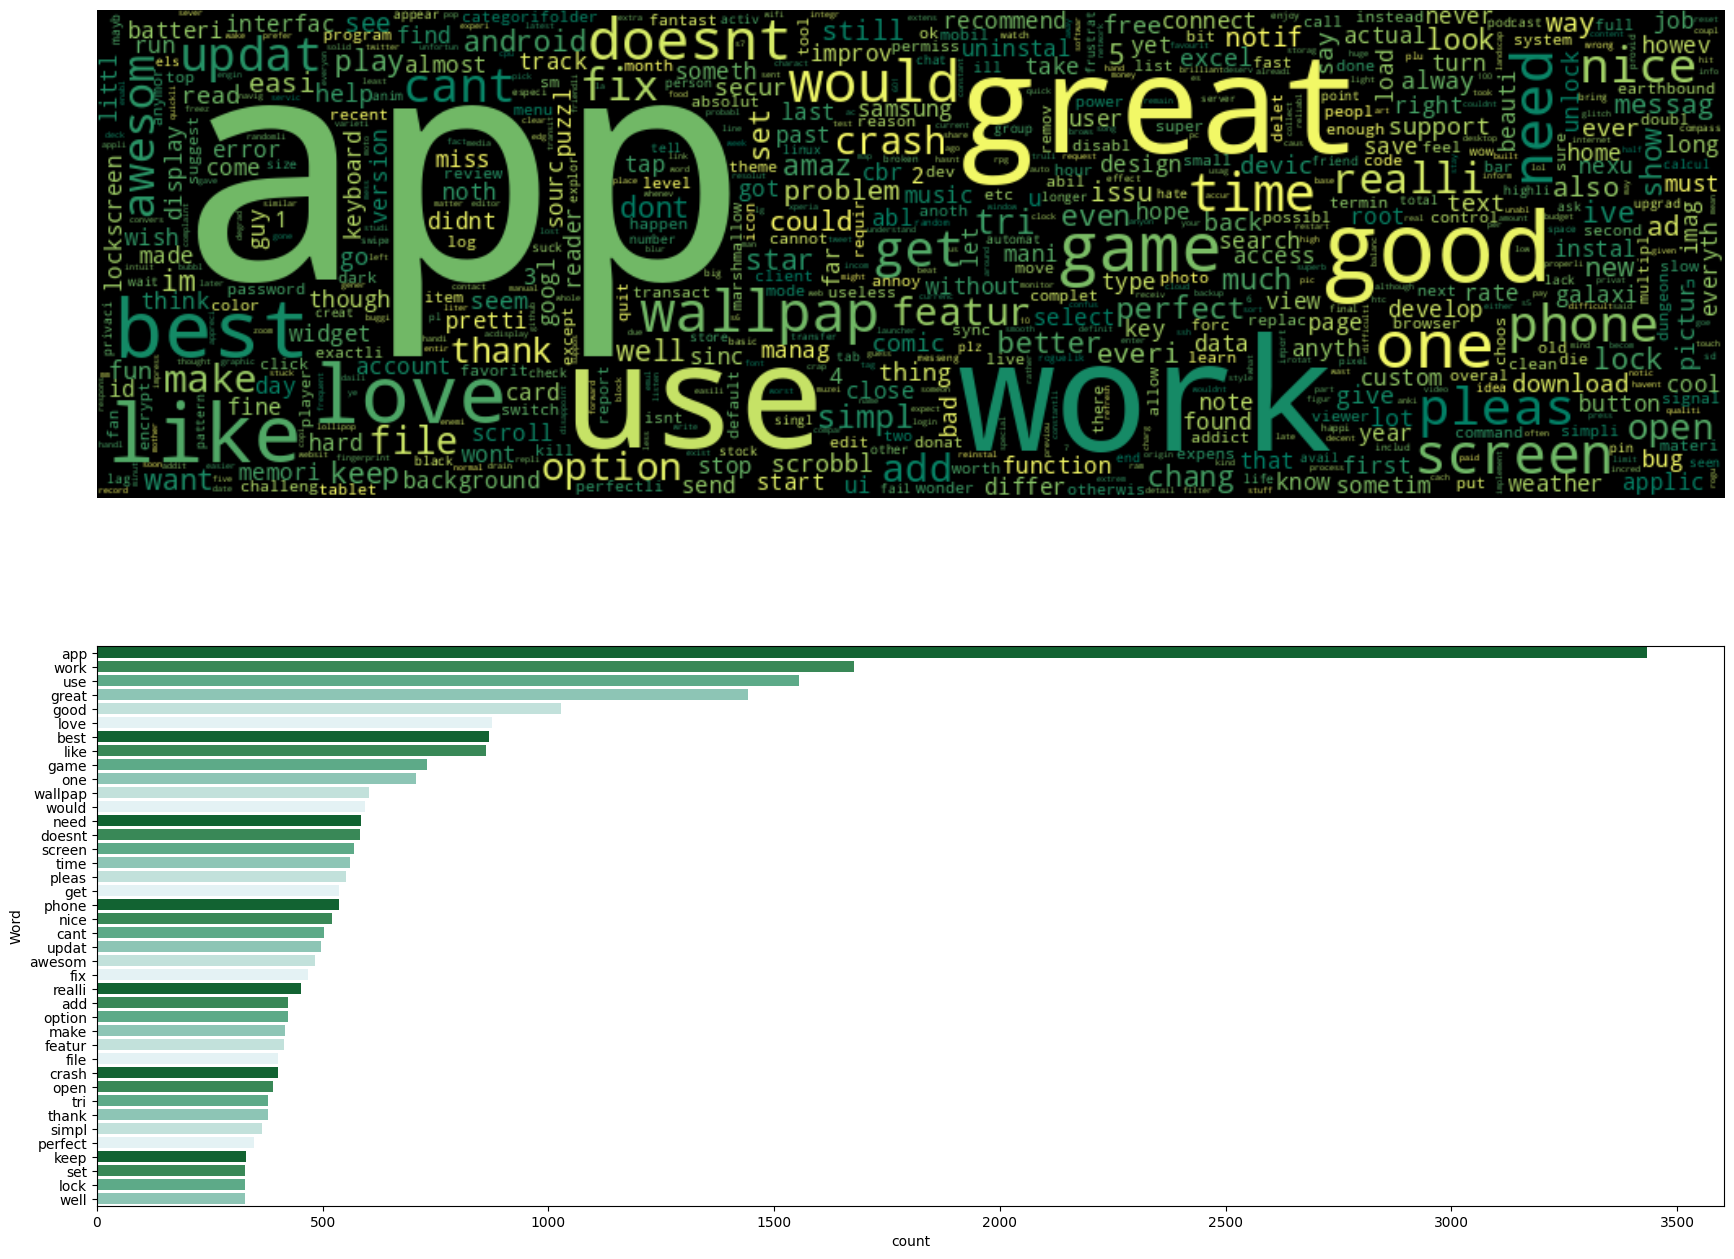

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


def word_cloud(x, terms = 40):
    all_words = ' '.join(x).split()

    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(freq_dist.keys()), 'count': list(freq_dist.values())})

    fig = plt.figure(figsize=(21,16))
    ax1 = fig.add_subplot(2,1,1)
    wordcloud = WordCloud(width=1000, height=300, background_color='black',
                          max_words=1628, relative_scaling=1, colormap='summer',
                          normalize_plurals=False).generate_from_frequencies(freq_dist)

    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')

    # select top 40 most frequent word
    ax2 = fig.add_subplot(2,1,2)
    d = words_df.nlargest(columns="count", n = terms)
    ax2 = sns.barplot(data=d, palette = sns.color_palette('BuGn_r'), x= "count", y = "word")
    ax2.set(ylabel= 'Word')
    plt.show()


word_cloud(dataset['reviewTextProc'])

# 1. RQ1: Classifying Reviews into defined categories

#### To what extent does the User Request Referencer organize reviews according to meaningful maintenance and evolution tasks for developers?



## 1.1 Performance Evaluation and plotting functions


In [7]:
from typing import NamedTuple
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from matplotlib.axes import Axes
from matplotlib.figure import Figure


class Performance(NamedTuple):
    cat: str
    f1: float
    precision: float
    recall: float
    accuracy: float

    def print(self):
        print(f'Precision : {self.precision:.1f}%')
        print(f'Recall : {self.recall:.1f}%')
        print(f'F1-score : {self.f1:.1f}%')


def get_performance(cat: str, y_true, y_pred) -> Performance:
    """
    Evaluate model prediction performance
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1score, support = score(y_true, y_pred, pos_label=1, average='binary')

    return Performance(cat, *[round(m * 100, 1) for m in [f1score, precision, recall, accuracy]])


def performance_to_df(perf: list[Performance]) -> pd.DataFrame:
    return pd.DataFrame(perf, columns=['Taxonomy', 'F1', 'Prec', 'Recall', 'Acc'])


def plot_classification_result(cls_res: pd.DataFrame, title: str):
    fig, ax = plt.subplots(ncols=2, figsize=(8, 6), sharey=True)
    fig: Figure
    ax: list[Axes]

    for a in ax:
        [a.spines[k].set_visible(False) for k in ['top', 'right', 'bottom', 'left']]

    args = dict(orient='v', color='#d0ffb4', inner="quartile")
    sns.violinplot(data=cls_res[['Prec', 'Recall', 'F1']], ax=ax[0], **args)
    # sns.violinplot(data=DF(np.log10(num_issues), columns=['Issue Reports']), ax=ax[1], **args)

    ax[0].set_ylabel('Ratio or Percentage')

    plt(title=title).show()

## 1.2 Prepare train/test datasets

### 2 added categories are included in this process namely BUG and FEATURE

In [8]:
from scipy import sparse
import random
from typing import NamedTuple


all_categories = ['APP USABILITY', 'UI', 'DEVICE', 'ANDROID VERSION', 'HARDWARE', 'PERFORMANCE', 'BATTERY', 'MEMORY', 'LICENSING', 'PRICE', 'PRIVACY', 'SECURITY', 'USAGE', 'COMPATIBILITY', 'RESSOURCES', 'PRICING', 'PROTECTION', 'ERROR', 'BUG', 'FEATURE']
# all_categories = ['APP USABILITY', 'UI', 'DEVICE', 'ANDROID VERSION', 'HARDWARE', 'PERFORMANCE', 'BATTERY', 'MEMORY', 'LICENSING', 'PRICE', 'PRIVACY', 'SECURITY']


class TrainTestSet(NamedTuple):
    x_train: sparse.csr_matrix
    y_train: np.ndarray
    x_test: sparse.csr_matrix
    y_test: np.ndarray


tfidf_vec = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
tfidf_vec.fit(dataset['reviewTextProc'].to_numpy())

count = 0


def prepare_train_test_set(cat: str) -> TrainTestSet:
    # test_set = pd.read_csv(f'Data/RQ_1/low/{cat}_final.csv', encoding='ISO-8859-1')
    test_set = pd.read_csv(f'Data/RQ_1_mod/{cat}_final.csv', encoding='UTF-8')

    # Clean test set
    test_set['reviewTextProc'] = test_set['reviewText'].apply(preprocess)

    length = len(dataset)

    # exclude those reviews from label_data2 that are in test dataset (by matching ids)
    df = dataset[~dataset._id.isin(test_set._id)]

    # Delete rows with empty subclasses from dataFrame
    indexNames = df[df['subclasses'] == '[]'].index
    df.drop(indexNames , inplace=True)

    # Set the percentage of data to exclude (80% in this case)
    percentage_of_training = 0.8

    # Calculate the number of rows to exclude
    rows_to_include = int(length * percentage_of_training)

    # Set a seed for reproducibility, so the random sampling will be the same each time
    seed = 42
    random_indices_to_include = dataset.sample(n=rows_to_include, random_state=seed).index

    # Exclude the selected rows from the original dataset
    df = dataset.loc[dataset.index.isin(random_indices_to_include)]

    # TF-IDF transform
    x_train = tfidf_vec.transform(df['reviewTextProc'].to_numpy())
    y_train = df[f'IS_{cat}'].to_numpy()


    x_test = tfidf_vec.transform(test_set['reviewTextProc'].to_numpy())
    y_test = test_set['Actual Label'].to_numpy()  # Actual Label = 'PREDICTED_{TAXONOMY}' xor 'CORRECT'

    # Resample: Use the same number of 1s and 0s (Since there are significantly more 0s than 1s)
    num_1s = sum(y_train)
    x_0s = x_train[y_train == 0]
    x_1s = x_train[y_train == 1]
    num_0s = min(num_1s, x_0s.shape[0])

    x_0s = x_0s[random.sample(range(x_0s.shape[0]), num_0s)]
    x_train = sparse.vstack([x_0s, x_1s])
    y_train = np.array([0] * num_0s + [1] * num_1s)
    assert len(y_train) == x_train.shape[0]

    global count
    count += 1

    return TrainTestSet(x_train, y_train, x_test, y_test)


train_test_sets = dict(zip(all_categories, map(prepare_train_test_set, all_categories)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


## 1.4 Classification and Evaluation using XGBoost

### Performance is evaluated on all the categories including the 2 added categories namely BUG and FEATURE.


In [9]:
import xgboost
count = 0

def classify_cat_xgboost(cat: str, n_estimators: int = 300) -> Performance:
    x_train, y_train, x_test, y_test = train_test_sets[cat]

    # turicreate model
    model = xgboost.XGBClassifier(tree_method='gpu_hist', n_estimators=n_estimators)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    global count
    count += 1

    # Performance metrics
    return get_performance(cat, y_test, pd.Series(y_pred))

classification_result_xg = list(map(classify_cat_xgboost, all_categories))
print(f'Mean f1: {float(np.mean([r.f1 for r in classification_result_xg])):.1f}%')
performance_to_df(classification_result_xg)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Mean f1: 54.9%


,Taxonomy,F1,Prec,Recall,Acc
0,APP USABILITY,67.6,51.9,97.0,53.0
1,UI,17.9,43.5,11.2,54.0
2,DEVICE,57.1,40.0,100.0,40.0
3,ANDROID VERSION,24.6,14.0,100.0,14.0
4,HARDWARE,5.3,100.0,2.7,82.0
5,PERFORMANCE,24.7,38.7,18.2,63.5
6,BATTERY,82.9,77.3,89.5,96.5
7,MEMORY,82.1,88.9,76.2,96.5
8,LICENSING,65.9,77.8,57.1,85.5
9,PRICE,65.3,62.7,68.1,83.0
